# 5.3 基于迁移学习技术来识别猫狗

## 采用端到端的模式从卷积基中提取特征，对应教材pp121-124

## 1 载模型
## 创建VGG16卷积基实例（即仅使用卷积层，而不使用全连接层作为分类器）

In [1]:
from keras.applications import VGG16

In [2]:
#创建VGG16实例，提前下载VGG16模型的h5文件，然后放置在C:\Users\Administrator\.keras\models
#include_top：是否包含Dense层
#weights：模型初始权重
conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150,150,3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### vgg16的卷积核包含5部分：
### 第1-2部分：Conv2D x 2 + MaxPooling2D
### 第3-5部分：Conv2D x 3 + MaxPooling2D
### 卷积核的输出特征维度为 4 x 4 x 512, 我们需要在此基础上扩展Dense层

## 2-3 加平层、加密层
## 往模型中添加Flatten层（即展平卷积基输出特征张量）
## 继续往模型中添加Dense层（即展平卷积基输出特征张量）

In [4]:
from keras import models
from keras import layers
from keras import optimizers

### 在端到端的模型中，先添加卷积基、再添加自定义的分类器

In [5]:
extened_vgg16 = models.Sequential()


extened_vgg16.add(conv_base)
#在上述VGG16卷积基基础上扩展Flatten层，分类器
extened_vgg16.add(layers.Flatten())
extened_vgg16.add(layers.Dense(256, activation = 'relu'))
#extened_vgg16.add(layers.Dropout(0.5)) #原书在该场景下没有配置dropout
extened_vgg16.add(layers.Dense(1, activation = 'sigmoid'))

In [6]:
#扩展后的模型参数非常之巨大，必须在GPU上运行
extened_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### 冻结卷积基参数

In [7]:
#查看卷积基VGG16的可训练权重
len(conv_base.trainable_weights)

26

#### Note：VGG16中共包含13个卷积层，每个卷积层包含1个权重矩阵、1个偏置矩阵，因此共有26个trainable_weights

In [8]:
#查看整个扩展模型的可训练权重
len(extened_vgg16.trainable_weights)

30

#### Note：扩展后的模型新增了两个密集分类器层，每个密集连接层包含1个权重矩阵、1个偏置矩阵，因此共有4个trainable_weights

### 利用属性trainable冻结卷积基参数

In [9]:
#维持VGG16卷积基所有权重参数不变，即冻结,特别注意一定要在编译模型之前修改此属性
conv_base.trainable = False

In [10]:
#再次查看整个扩展模型的可训练权重
len(extened_vgg16.trainable_weights)

4

#### Note: 冻结VGG16卷积基部分后，再次查看扩展后模型的可训练权重数由30变为4

### 编译模型

In [11]:
#extened_vgg16.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
extened_vgg16.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = 'binary_crossentropy', metrics = ['acc'])

## 4 理图形
## 使用ImageDataGenerator预处理图片集（读取图片、张量转换、归一化、数据增强等）

### 可以使用“数据增强”来进一步解决过拟合问题

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

### 创建Generator实例

In [13]:
# #配置数据集目录
import os
base_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

### 场景1：不使用数据增强技术

In [14]:
# # #对训练集进行数据增强
# train_datagen = ImageDataGenerator(
#     rescale = 1./255)

# train_generator = train_datagen.flow_from_directory(train_dir,target_size = (150,150), 
#                                                      batch_size = 20, 
#                                                      class_mode = 'binary')

### 场景2：使用数据增强技术

In [15]:
#对训练集进行数据增强
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')


train_generator = train_datagen.flow_from_directory(train_dir,target_size = (150,150), 
                                                     batch_size = 20, 
                                                     class_mode = 'binary')

Found 2000 images belonging to 2 classes.


### 验证集原则上不使用数据增强技术

In [16]:
#对验证集进行数据增强, 特别注意验证集不能使用数据增强
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size = (150,150), 
                                                              batch_size = 20, 
                                                              class_mode = 'binary')

Found 1000 images belonging to 2 classes.


## 5 练不停

In [17]:
import time

start = time.time()

history_extened_vgg16 = extened_vgg16.fit_generator(train_generator, 
                                                     epochs = 30, 
                                                     steps_per_epoch = 100, 
                                                     validation_data = validation_generator, 
                                                     validation_steps = 50)

end = time.time()

print("训练耗时(s)：%d"%(end - start))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 336s 3s/step - loss: 0.5953 - acc: 0.6935 - val_loss: 0.4568 - val_acc: 0.8280
Epoch 2/30
100/100 [==============================] - 333s 3s/step - loss: 0.4955 - acc: 0.7695 - val_loss: 0.3714 - val_acc: 0.8620
Epoch 3/30
100/100 [==============================] - 335s 3s/step - loss: 0.4302 - acc: 0.8120 - val_loss: 0.3285 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 324s 3s/step - loss: 0.3973 - acc: 0.8305 - val_loss: 0.3038 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 330s 3s/step - loss: 0.3903 - acc: 0.8220 - val_loss: 0.2887 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 326s 3s/step - loss: 0.3652 - acc: 0.8470 - val_loss: 0.2799 - val_acc: 0.8830
Epoch 7/30
100/100 [==============================] - 325s 3s/step - loss: 0.3599 - acc: 0.8375 - val_loss: 0.2727 - val_acc: 

In [18]:
#extened_vgg16.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_2_extened_vgg16_without_data_augment.h5')
#extened_vgg16.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_2_extened_vgg16_with_data_augment_with_droupout.h5')
extened_vgg16.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_2_extened_vgg16_with_data_augment_without_droupout.h5')

## 6 评估模型

### 6.1 评估模型在验证集上的表现

In [19]:
import matplotlib.pyplot as plt

train_acc = history_extened_vgg16.history['acc']
val_acc = history_extened_vgg16.history['val_acc']
train_loss = history_extened_vgg16.history['loss']
val_loss = history_extened_vgg16.history['val_loss']

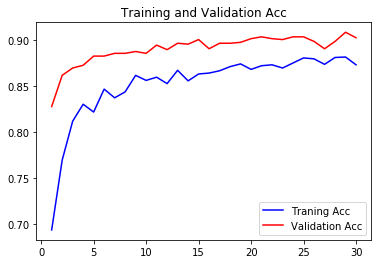

In [20]:
epochs = range(1, len(train_acc)+1)

plt.plot(epochs, train_acc, 'b', label = 'Traning Acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation Acc')

plt.title('Training and Validation Acc')
plt.legend()
plt.show()

In [25]:
max(val_acc)

0.9089999794960022

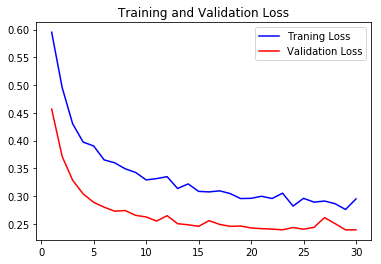

In [21]:
plt.plot(epochs, train_loss, 'b', label = 'Traning Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')

plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 6.2 评估测试图片

In [39]:
import numpy as np
def preprocess_img(img):
    x1 = image.img_to_array(img)
    x2 = x1 * 1./255
    x3 = np.expand_dims(x2, axis = 0)
    return x3

In [51]:
# from keras.models import load_model
# my_network = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_2_extened_vgg16_with_data_augment.h5')

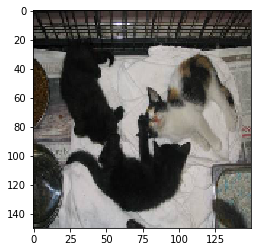

In [52]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/cats/cat.12436.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [53]:
pred = my_network.predict(preprocess_img(img2))
pred

array([[0.06734377]], dtype=float32)

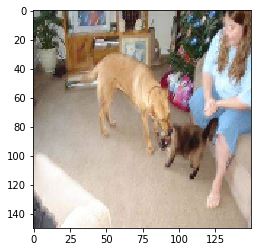

In [54]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12005.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [55]:
pred = my_network.predict(preprocess_img(img2))
pred

array([[0.8890577]], dtype=float32)

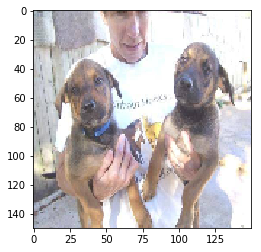

In [56]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12003.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [57]:
pred = my_network.predict(preprocess_img(img2))
pred

array([[0.8502578]], dtype=float32)

 ### 6.3 评估模型在测试集上的表现

In [58]:
import os
from keras.preprocessing import image

classes = ['cats','dogs']
files_name = []
test_true_labels = []
test_pred_labels = []
test_pred_probs = []

for c in classes:
    test_class_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/{}'.format(c)
    for f in os.listdir(test_class_dir):
        
        files_name.append(f)
        test_true_labels.append(f[0:3])
        
        img_path = os.path.join(test_class_dir, f)
        img = image.load_img(img_path, target_size = (150, 150))
        pred = my_network.predict(preprocess_img(img))
        test_pred_probs.append(pred)
        
        pred_label = None
        if pred[0] > 0.5:
            pred_label = 'dog'
        else:
            pred_label = 'cat'
        test_pred_labels.append(pred_label)  

In [59]:
import pandas as pd
df = pd.DataFrame(data={'file':files_name, 'true_label':test_true_labels,  'pred_label':test_pred_labels, 'pred_prob':test_pred_probs})
pred_error_records = df[df['true_label'] != df['pred_label']].shape[0]
error_rate = float(pred_error_records)/float(1000)
error_rate

0.104

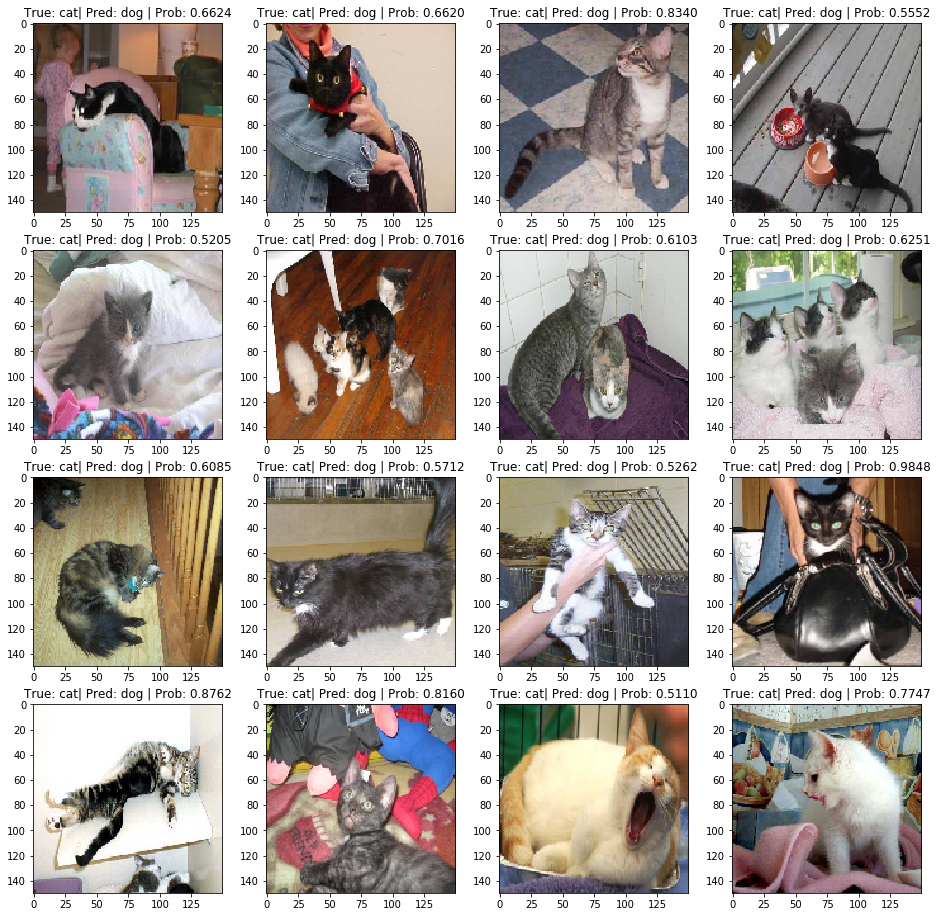

In [16]:
df_error = df[(df['true_label'] != df['pred_label']) & (df['true_label'] == 'cat')]

#对分类错误记录进行随机抽取，每次抽取16行记录，可以反复运行此段代码，随机查看分类错误图片
df_error_sample = df_error.sample(n=16, replace = False, axis = 0)
files_error = list(df_error_sample['file'])
true_labels_error =  list(df_error_sample['true_label'])
pred_labels_error =  list(df_error_sample['pred_label'])
pred_probs_error = list(df_error_sample['pred_prob'])


import matplotlib.pyplot as plt
n_rows= 4
n_cols= 4 

#16个分类错误记录用4x4图片排布展现出来
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        img_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/cats/{}'.format(files_error[c])
        image_error = image.load_img(img_dir, target_size = (150,150))
        
        axs[i][j].imshow(image_error);
        axs[i][j].set_title('True: {}| Pred: {} | Prob: {:.4f}'.format(true_labels_error[c], pred_labels_error[c], pred_probs_error[c][0][0]));
        c+=1

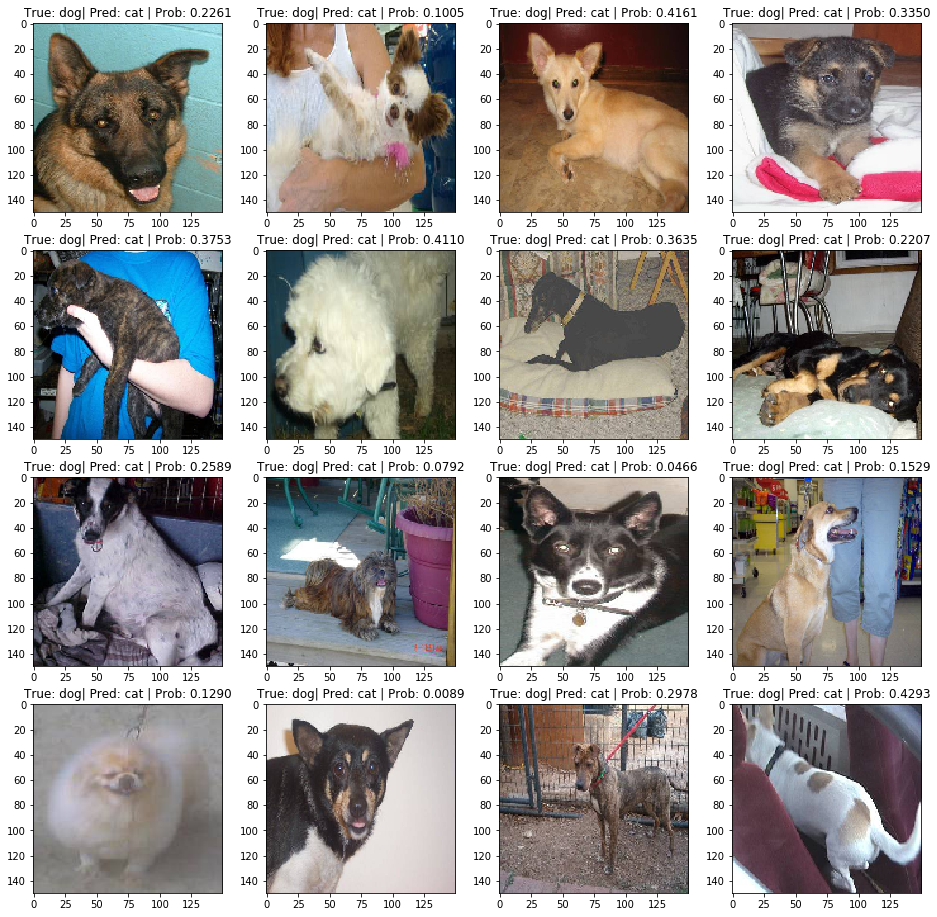

In [17]:
df_error = df[(df['true_label'] != df['pred_label']) & (df['true_label'] == 'dog')]
#对分类错误记录进行随机抽取，每次抽取16行记录，可以反复运行此段代码，随机查看分类错误图片
df_error_sample = df_error.sample(n=16, replace = False, axis = 0)
files_error = list(df_error_sample['file'])
true_labels_error =  list(df_error_sample['true_label'])
pred_labels_error =  list(df_error_sample['pred_label'])
pred_probs_error = list(df_error_sample['pred_prob'])


import matplotlib.pyplot as plt
n_rows= 4
n_cols= 4 

#16个分类错误记录用4x4图片排布展现出来
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        img_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/dogs/{}'.format(files_error[c])
        image_error = image.load_img(img_dir, target_size = (150,150))
        
        axs[i][j].imshow(image_error);
        axs[i][j].set_title('True: {}| Pred: {} | Prob: {:.4f}'.format(true_labels_error[c], pred_labels_error[c], pred_probs_error[c][0][0]));
        c+=1